In [1]:
import json
import os
import numpy as np

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_pos_att_losses"]["values"], axis=1)]))
    return all_vals

In [9]:
noprior_vals = print_validation_profile_and_prior_losses("SPI1_noneg")

Best profile loss overall:
	Best run: 3
	Best epoch in run: 9
	Associated value: 143.4285297817654
Best epoch in each run:
	Run 1, epoch 10: 143.46
	Run 2, epoch 8: 143.46
	Run 3, epoch 9: 143.43
	Run 4, epoch 10: 143.47
	Run 5, epoch 10: 143.44
	Run 6, epoch 10: 143.84
	Run 7, epoch 10: 143.70
	Run 8, epoch 10: 143.53
	Run 9, epoch 8: 143.57
	Run 10, epoch 10: 143.55
	Run 11, epoch 10: 144.05
	Run 12, epoch 10: 143.55
	Run 13, epoch 2: 147.85
All validation profile and prior losses:
1
	164.24 150.25 147.88 146.85 146.22 145.87 145.54 145.37 145.21 145.05
	149.78 147.24 145.72 144.75 144.37 144.17 143.81 143.66 143.59 143.46
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	161.94 150.33 148.17 146.87 146.19 145.79 145.44 145.24 145.06 144.89
	150.56 146.90 145.74 144.60 144.20 144.10 143.85 143.46 143.56 143.82
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
3
	158.91 149.29 147.89 146.80 146.28 145.89 145.56 145.29 145.12 145.00
	149.17 

In [10]:
prior_vals = print_validation_profile_and_prior_losses("SPI1_prior_noneg")

Best profile loss overall:
	Best run: 1
	Best epoch in run: 10
	Associated value: 144.08977644178603
Best epoch in each run:
	Run 1, epoch 10: 144.09
	Run 2, epoch 10: 144.21
	Run 3, epoch 10: 144.23
	Run 4, epoch 10: 144.20
	Run 5, epoch 10: 144.30
	Run 6, epoch 10: 144.18
	Run 7, epoch 1: 149.97
All validation profile and prior losses:
1
	162.14 150.00 148.07 147.25 146.74 146.45 146.20 145.95 145.81 145.65
	149.11 146.98 146.24 145.27 144.83 144.48 144.34 144.52 144.29 144.09
	0.1960 0.0952 0.0818 0.0718 0.0661 0.0618 0.0597 0.0542 0.0557 0.0532
2
	163.46 151.41 148.93 147.69 147.13 146.75 146.49 146.24 146.11 145.97
	151.43 148.30 146.03 145.95 145.02 144.84 144.89 144.34 144.31 144.21
	0.2752 0.0934 0.0818 0.0716 0.0683 0.0647 0.0602 0.0613 0.0570 0.0541
3
	165.22 150.74 148.80 147.80 147.20 146.76 146.53 146.28 146.10 145.95
	150.62 148.20 146.32 145.98 145.23 145.31 144.73 144.74 144.29 144.23
	0.1707 0.1024 0.0766 0.0736 0.0663 0.0590 0.0585 0.0565 0.0571 0.0546
4
	164.41 151.7

In [6]:
import matplotlib.pyplot as plt

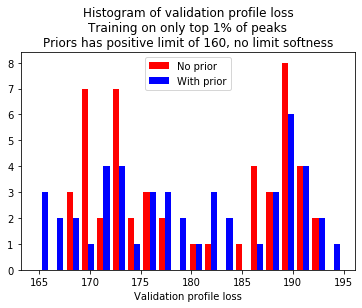

In [72]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss"
title += "\nTraining on only top 1% of peaks"
title += "\nPriors has positive limit of 160, no limit softness"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [53]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))

In [43]:
import scipy.stats

In [58]:
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

2.299804987643595
0.012201333463147754
